# My Book Recommendation Project Summary

## 1. Pearson Correlation-Based Recommendations
**Objective:** I wanted to recommend books similar to a given book based on user rating patterns.

**What I did:**
1. Loaded the **books, users, and ratings datasets** and cleaned the data.  
2. Calculated **average ratings** and **rating counts** for each book.  
3. Filtered out **inactive users** (less than 200 ratings) and **less popular books** (less than 100 ratings) to make the results statistically meaningful.  
4. Created a **user-book ratings matrix** with users as rows and books as columns.  
5. Calculated **Pearson correlation** between the selected book’s ratings and all other books.  
6. Recommended books that had **high correlation** and enough ratings.  

**Key Idea:** Using Pearson correlation, I could find books that were rated similarly by the **same users**, showing a linear relationship between their ratings.

---

## 2. k-Nearest Neighbors (kNN) Collaborative Filtering
**Objective:** I used kNN to recommend books based on the similarity of their rating patterns across all users.

**What I did:**
1. Cleaned and filtered the ratings dataset to include only users from **US and Canada**.  
2. Converted the ratings into a **book-user matrix**, filling missing ratings with zeros.  
3. Converted the matrix into a **sparse format** for faster computation.  
4. Built a **kNN model** using **cosine similarity** to find the nearest neighbors for any book.  
5. Queried the model to get the **top similar books** for a randomly chosen book.  

**Key Idea:** kNN helped me find books whose **rating patterns across users** were most similar, using cosine similarity as the metric.


In [17]:
# Import required libraries
import pandas as pd   # For data manipulation and analysis
import numpy as np    # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


# Load the books dataset
# - Read all columns as strings to avoid mixed dtype warnings
# - Will convert 'yearOfPublication' to numeric later to handle invalid entries
books = pd.read_csv(
    'BX-Books.csv',
    sep=';',                 # CSV uses semicolons as separators
    on_bad_lines="skip",     # Skip any problematic lines
    encoding="latin-1",      # Handle special characters in book titles/authors
    dtype=str                # Read all columns as string initially
)

# Rename columns to make them easier to reference
books.columns = [
    'ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication',
    'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL'
]

# Convert 'yearOfPublication' to numeric
# - Any invalid or non-numeric entries become NaN
books['yearOfPublication'] = pd.to_numeric(books['yearOfPublication'], errors='coerce')

# Load the users dataset
# - on_bad_lines="skip" skips any corrupted rows
users = pd.read_csv('BX-Users.csv', sep=';', on_bad_lines="skip", encoding="latin-1")
# Rename columns for clarity
users.columns = ['userID', 'Location', 'Age']

# Load the ratings dataset
# - Contains which user rated which book and the rating score
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', on_bad_lines="skip", encoding="latin-1")
# Rename columns for clarity
ratings.columns = ['userID', 'ISBN', 'bookRating']

In [5]:
# Check the shape of the ratings dataset
# - .shape returns a tuple (number of rows, number of columns)
#   so I can see how many ratings and columns I have
print(ratings.shape)

# Check the column names of the ratings dataset
# - list() converts the Index object to a regular Python list for easy reading
#   This helps me verify that column names are correct
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


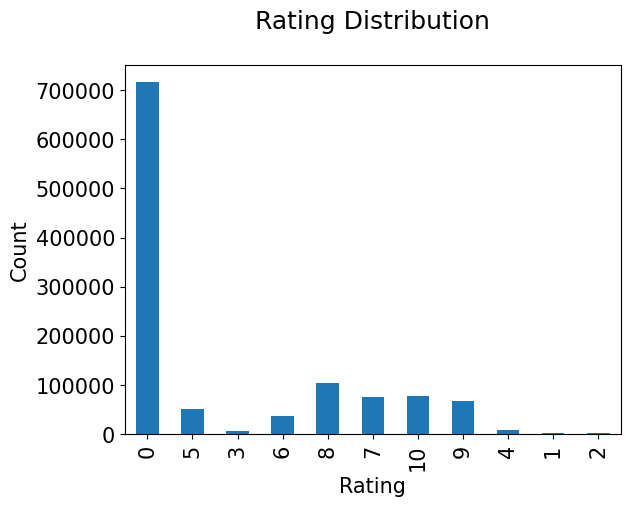

In [6]:
# Set the default font size for plots to make them more readable
plt.rc("font", size=15)

# Plot a bar chart showing the distribution of book ratings
# - ratings.bookRating.value_counts(sort=False) counts how many times each rating occurs
# - sort=False ensures ratings appear in numerical order (e.g., 0, 1, 2, …)
# - plot(kind='bar') creates a vertical bar chart
ratings.bookRating.value_counts(sort=False).plot(kind='bar')

# Set the title and axis labels for clarity
plt.title('Rating Distribution\n')  # Add a title to the plot
plt.xlabel('Rating')                 # Label x-axis
plt.ylabel('Count')                  # Label y-axis

# Save the plot as an image file
# - bbox_inches='tight' ensures nothing is cut off in the saved image
plt.savefig('system1.png', bbox_inches='tight')

# Display the plot
plt.show()

In [7]:
# Check the shape of the books dataset
# - .shape returns a tuple (number of rows, number of columns)
#   so I can see how many books and features are in the dataset
print(books.shape)

# Check the column names of the books dataset
# - list() converts the Index object to a regular Python list for easy reading
#   This helps verify that all expected columns are present
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [8]:
# Check the shape of the users dataset
# - .shape returns a tuple (number of rows, number of columns)
#   which tells me how many users and features are present
print(users.shape)

# Check the column names of the users dataset
# - list() converts the Index object to a Python list for easy viewing
#   This helps me confirm that all expected columns are present
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


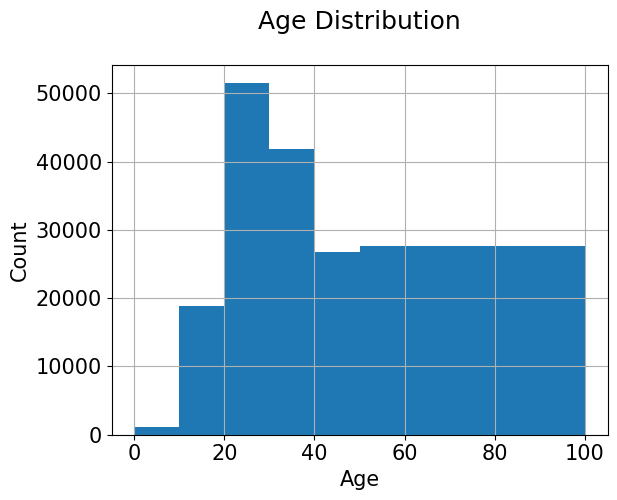

In [9]:
# Plot a histogram of user ages
# - users.Age.hist() creates a histogram of the Age column
# - bins define the ranges for age groups: 0-10, 10-20, ..., 50-100
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])

# Set the title and axis labels for clarity
plt.title('Age Distribution\n')  # Add a title to the plot
plt.xlabel('Age')                # Label x-axis
plt.ylabel('Count')              # Label y-axis

# Save the plot as an image file
# - bbox_inches='tight' ensures nothing is cut off in the saved image
plt.savefig('system2.png', bbox_inches='tight')

# Display the plot
plt.show()

# Recommendation Based on Rating Counts

In [11]:
# Count the number of ratings for each book (grouped by ISBN)
# - Group the ratings dataset by 'ISBN'
# - Use .count() to find how many ratings each book received
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())

# Sort the books by the number of ratings in descending order
# - Books with the most ratings appear first
# - .head() shows the top 5 most-rated books
rating_count.sort_values('bookRating', ascending=False).head()

,bookRating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


# The book with ISBN “0971880107” received the most rating counts. Let’s find out what book it is, and what books are in the top 5.

In [12]:
# Create a DataFrame containing the ISBNs of the top 5 most-rated books
# - These ISBNs were identified from the previous rating_count step
most_rated_books = pd.DataFrame(
    ['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], 
    index=np.arange(5),           # Set the index from 0 to 4
    columns=['ISBN']              # Name the column as 'ISBN'
)

# Merge the most-rated books with the books dataset to get book details
# - This allows us to see the title, author, publisher, etc.
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')

# Display the summary of the top 5 most-rated books
most_rated_books_summary

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


# Recommendations Based on Correlations

We can generate book recommendations using **Pearson’s R correlation coefficient**, which measures the **linear correlation** between two variables. In our case, the variables are the **ratings given to two different books**.



## Step 1: Calculate Average Rating and Number of Ratings per Book

Before calculating correlations, it’s important to know:

1. **Average rating of each book** – this helps understand the general user preference for the book.  
2. **Number of ratings each book received** – this ensures we focus only on books with sufficient feedback to make reliable recommendations.

By focusing on books with both a **high number of ratings** and a **meaningful average rating**, we improve the quality of the correlation-based recommendations.


In [13]:
# Calculate the average rating for each book
# - Group the ratings dataset by 'ISBN'
# - Use .mean() to get the average rating per book
average_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())

# Add a new column to store the number of ratings each book received
# - This helps identify popular books with enough feedback
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())

# Sort the books by the number of ratings in descending order
# - Shows the most-rated books at the top
# - .head() displays the top 5 books
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


## Observations

In this dataset, the book that received the **most ratings** was **not highly rated**.  

As a result, if we were to generate recommendations **based solely on rating counts**, we might make **incorrect suggestions**, recommending books that are popular but not well-liked.  

This indicates the need for a **better recommendation system**, such as one based on **correlations or similarity between user ratings**.

## Data Filtering for Statistical Significance

To ensure **statistical significance** in our recommendations:

- Users who have provided **less than 200 ratings** are excluded.  
- Books that have received **less than 100 ratings** are excluded.  

This filtering helps focus on **active users** and **popular books**, improving the reliability of correlation-based recommendations.


In [14]:
# Count the number of ratings given by each user
# - This helps identify active users who rated many books
counts1 = ratings['userID'].value_counts()

# Keep only users who have rated at least 200 books
# - Ensures that recommendations are based on users with sufficient activity
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]

# Count the number of times each book has been rated
# - This helps identify popular books with enough ratings
counts = ratings['bookRating'].value_counts()

# Keep only books that have been rated at least 100 times
# - Ensures statistical significance and reliable correlation calculations
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

## Rating Matrix

We convert the **ratings table** into a **2D matrix** (books × users):

- Rows represent **books**.  
- Columns represent **users**.  
- Each cell contains the **rating** given by a user to a book.  

The matrix will be **sparse** because not every user has rated every book.  

This structure is necessary for **correlation calculations** and other similarity-based recommendation methods.


In [15]:
# Convert the ratings table into a 2D pivot table (user-book matrix)
# - Rows: users (userID)
# - Columns: books (ISBN)
# - Values: book ratings
ratings_pivot = ratings.pivot(index='userID', columns='ISBN').bookRating

# Store the list of users and books for later reference
userID = ratings_pivot.index   # All unique users
ISBN = ratings_pivot.columns   # All unique books

# Print the shape of the pivot table
# - Shows number of users (rows) and books (columns)
print(ratings_pivot.shape)

# Display the first few rows of the pivot table
# - Gives a quick look at the structure and missing values
ratings_pivot.head()

(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
userID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Select the rating vector for a specific book ('Bones')
# - This is the book we want to find similar books for
bones_ratings = ratings_pivot['0316666343']

# Compute Pearson correlation of 'Bones' with all other books
# - corrwith calculates correlation between the selected book and every other book
similar_to_bones = ratings_pivot.corrwith(bones_ratings)

# Convert the correlation Series into a DataFrame for easier handling
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])

# Drop any rows with NaN values
# - These occur if a book has no overlapping ratings with 'Bones'
corr_bones.dropna(inplace=True)

# Join with the average rating count for each book
# - This allows us to filter out books with too few ratings
corr_summary = corr_bones.join(average_rating['ratingCount'])

# Filter books that have at least 300 ratings
# - Sort by Pearson correlation in descending order to find top 10 similar books
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,ratingCount
ISBN,,
0316666343,1.000000,1295
0312291639,0.471872,354
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0385265700,0.351635,319
0345342968,0.316922,321
0060930535,0.309860,494
0375707972,0.308145,354


## Mapping ISBNs to Book Titles

At this stage, we have obtained the **ISBNs of recommended books** based on correlations.  

However, ISBNs alone are not very informative. To make the recommendations understandable, we need to **map these ISBNs back to their book titles**.  

This allows us to:

- Verify whether the recommended books **make sense**.  
- Present a **readable list of book recommendations** to users.  
```

In [19]:
# Create a DataFrame with ISBNs of books that are most correlated to 'Bones'
# - These ISBNs were obtained from the correlation analysis
books_corr_to_bones = pd.DataFrame(
    ['0312291639', '0316601950', '0446610038', '0446672211', '0385265700', 
     '0345342968', '0060930535', '0375707972', '0684872153'], 
    index=np.arange(9),     # Index from 0 to 8
    columns=['ISBN']        # Column name 'ISBN'
)

# Merge the correlated ISBNs with the books dataset
# - This retrieves book titles, authors, and other details
corr_books = pd.merge(books_corr_to_bones, books, on='ISBN')

# Display the recommended books with their details
corr_books

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003.0,St. Martin's Griffin,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...
1,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999.0,Back Bay Books,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...
2,0446610038,1st to Die: A Novel,James Patterson,2002.0,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...
3,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
4,0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990.0,Anchor,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...
5,0345342968,Fahrenheit 451,RAY BRADBURY,1987.0,Del Rey,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...
6,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999.0,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
7,0375707972,The Reader,Bernhard Schlink,1999.0,Vintage Books USA,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...
8,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999.0,Scribner,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...


# Collaborative Filtering Using k-Nearest Neighbors (kNN)

**k-Nearest Neighbors (kNN)** is a machine learning algorithm used to:

- Find clusters of **similar users** based on their **common book ratings**.  
- Make predictions for a user by considering the **average rating of the top-k nearest neighbors** (most similar users).

### How it Works:

1. **Ratings Matrix**
   - Represent the dataset as a **matrix**:
     - **Rows**: Items (books)  
     - **Columns**: Users  
     - **Values**: Ratings given by users to books
     
2. **Similarity Calculation**
   - Compute **similarity** between users or items (e.g., using **cosine similarity**).  

3. **Prediction**
   - For a target user and book, predict the rating using the **ratings from k most similar users**.  
   - This allows the system to recommend books **based on the preferences of similar users**.

✅ **Key Benefit:**  
- kNN-based collaborative filtering can capture **hidden patterns in user behavior**, providing personalized recommendations even for users who have not rated many books.


In [22]:
# Merge the ratings dataset with the books dataset
# - This combines user ratings with book details (like title and ISBN)
combine_book_rating = pd.merge(ratings, books, on='ISBN')

# Drop unnecessary columns to simplify the dataset for kNN
# - Remove columns like yearOfPublication, publisher, author, and image URLs
columns_to_drop = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns=columns_to_drop, axis=1)

# Display the first few rows of the combined dataset
# - Ensures that merging and column removal worked correctly
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,276726,0155061224,5,Rites of Passage
2,276727,0446520802,0,The Notebook
3,276729,052165615X,3,Help!: Level 1
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...


## Total Rating Count per Book

Next, we **group the dataset by book titles** and calculate the **total number of ratings each book received**.  

- This helps identify **popular books** with enough ratings for reliable recommendations.  
- The total rating count is stored in a **new column**, which can be used later for filtering or analysis.

In [23]:
# Remove any rows where 'bookTitle' is missing
# - Ensures we only analyze books with valid titles
combine_book_rating = combine_book_rating.dropna(axis=0, subset=['bookTitle'])

# Group the combined dataset by 'bookTitle' and count the number of ratings
# - .groupby('bookTitle')['bookRating'].count() computes total ratings per book
# - .reset_index() converts the result back into a DataFrame
# - .rename(...) renames the column to 'totalRatingCount'
# - Select only 'bookTitle' and 'totalRatingCount' columns for clarity
book_ratingCount = (
    combine_book_rating
    .groupby(by=['bookTitle'])['bookRating']
    .count()
    .reset_index()
    .rename(columns={'bookRating': 'totalRatingCount'})
    [['bookTitle', 'totalRatingCount']]
)

# Display the first few rows of the rating count summary
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


## Combining Rating Data with Total Rating Count

We merge the **original rating data** with the **total rating count** per book:

- This provides a complete view of each book, including **individual user ratings** and **overall popularity**.  
- With this combined data, we can easily identify **popular books** and **filter out lesser-known books** with too few ratings.  
- This step is crucial for **improving the reliability of kNN recommendations**.

In [24]:
# Merge the combined book ratings with the total rating count per book
# - left_on and right_on specify the column to merge on ('bookTitle')
# - how='left' ensures all original ratings are kept, adding totalRatingCount to each row
rating_with_totalRatingCount = combine_book_rating.merge(
    book_ratingCount, 
    left_on='bookTitle', 
    right_on='bookTitle', 
    how='left'
)

# Display the first few rows of the merged dataset
# - Each row now contains: userID, ISBN, bookTitle, bookRating, totalRatingCount
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,276726,0155061224,5,Rites of Passage,14
2,276727,0446520802,0,The Notebook,650
3,276729,052165615X,3,Help!: Level 1,1
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,1


In [25]:
# Set pandas display option to show floats with 3 decimal places
# - Makes output easier to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Display summary statistics of total rating counts for all books
# - .describe() provides count, mean, std, min, max, and quartiles
print(book_ratingCount['totalRatingCount'].describe())

count   241071.000
mean         4.277
std         16.739
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       2502.000
Name: totalRatingCount, dtype: float64


## Observing the Distribution of Ratings

From the summary statistics:

- The **median book** has been rated **only once**, indicating that most books receive very few ratings.  
- To better understand **popular books**, we need to focus on the **top of the distribution**, i.e., books with many ratings.  
- This helps in **filtering out lesser-known books** and improving the reliability of recommendations.

In [26]:
# Calculate the quantiles of total rating counts for the top 10% of books
# - np.arange(.9, 1, .01) generates quantiles from 90% to 99% in steps of 1%
# - This helps us understand the distribution among the most-rated books
print(book_ratingCount['totalRatingCount'].quantile(np.arange(0.9, 1, 0.01)))

0.900    7.000
0.910    8.000
0.920    9.000
0.930   10.000
0.940   11.000
0.950   13.000
0.960   16.000
0.970   20.000
0.980   29.000
0.990   50.000
Name: totalRatingCount, dtype: float64


In [27]:
# Set a popularity threshold to filter books
# - Only books with at least 50 ratings will be considered
popularity_threshold = 50

# Filter the dataset to include only popular books
# - Use pandas query method with the threshold variable
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')

# Display the first few rows of the filtered dataset
# - Ensures that only books meeting the popularity threshold are included
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
2,276727,0446520802,0,The Notebook,650
6,276744,038550120X,7,A Painted House,838
7,276746,0425115801,0,Lightning,274
8,276746,0449006522,0,Manhattan Hunt Club,111


In [28]:
# Display the shape of the filtered dataset
# - Shows the number of rows (ratings) and columns after filtering popular books
rating_popular_book.shape

(288740, 5)

## Filter to Users in US and Canada

Next, we focus on **users located in the United States and Canada**:

- This allows us to **analyze ratings from a specific region**, which can be useful for localized recommendations.  
- Filtering by location ensures the model learns from **relevant user preferences**, reducing noise from users in other countries.  
- We will also remove the 'Age' column since it is **not required** for this part of the analysis.

In [29]:
# Merge the popular book ratings with user information
# - Adds user location and age to each rating
combined = rating_popular_book.merge(users, left_on='userID', right_on='userID', how='left')

# Filter to include only users from the US or Canada
# - Uses string matching with 'usa' or 'canada' (case-insensitive)
us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]

# Drop the 'Age' column since it is not needed for kNN analysis
us_canada_user_rating = us_canada_user_rating.drop('Age', axis=1)

# Display the first few rows to verify the filtered dataset
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,276725,034545104X,0,Flesh Tones: A Novel,60,"tyler, texas, usa"
2,276744,038550120X,7,A Painted House,838,"torrance, california, usa"
7,276747,0060517794,9,Little Altars Everywhere,85,"iowa city, iowa, usa"
8,276747,0451192001,0,How Stella Got Her Groove Back,210,"iowa city, iowa, usa"
9,276747,0609801279,0,The Law of Love,56,"iowa city, iowa, usa"


# Implementing k-Nearest Neighbors (kNN) for Book Recommendations

### Step 1: Convert Ratings to a 2D Matrix
- Transform the `us_canada_user_rating` table into a **matrix format**:
  - **Rows** represent books.  
  - **Columns** represent users.  
  - **Values** are ratings given by users to books.
- Fill **missing values with zeros** because not every user has rated every book.  
- Convert the matrix into a **scipy sparse matrix** for **more efficient computations**, especially for large datasets.

### Step 2: Finding the Nearest Neighbors
- Use **unsupervised algorithms** from `sklearn.neighbors` to find similar books.  
- Algorithm setup:
  - `algorithm="brute"` → computes distances by comparing all rows.  
  - `metric="cosine"` → calculates **cosine similarity** between rating vectors.  
- Fit the kNN model to the sparse ratings matrix.
- This allows us to **identify books that are most similar in user ratings** to a target book.

In [31]:
# Import csr_matrix for creating a sparse matrix
from scipy.sparse import csr_matrix

# Remove duplicate ratings for the same user-book pair
# - Ensures each user-book combination appears only once
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])

# Pivot the dataset to create a ratings matrix
# - Rows: book titles
# - Columns: users
# - Values: ratings
# - Fill missing ratings with 0 (required for distance calculations)
us_canada_user_rating_pivot = us_canada_user_rating.pivot(
    index='bookTitle',
    columns='userID',
    values='bookRating'
).fillna(0)

# Convert the ratings matrix to a sparse matrix for efficient computation
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

# Import kNN algorithm from scikit-learn
from sklearn.neighbors import NearestNeighbors

# Initialize the kNN model
# - metric='cosine' → uses cosine similarity
# - algorithm='brute' → compares all rows for distance calculation
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')

# Fit the model on the sparse ratings matrix
# - Prepares the model to find the nearest neighbors for any book
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [36]:
# Select the rating vector for a specific book using its row index (query_index)
# - iloc[query_index, :] → selects the row corresponding to the book
# - .values → converts the row to a NumPy array
# - .reshape(1, -1) → reshapes it into a 2D array with 1 row and as many columns as users
query_vector = us_canada_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1)

# Display the vector to check its values
# - Ensures the selected book's ratings across all users are correctly captured
print(query_vector)


[[0. 0. 0. ... 0. 0. 0.]]


In [37]:
import numpy as np

# Select a random book row index from the pivot table
# - np.random.choice selects one index randomly from the total number of books
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print("Query book row index:", query_index)

# Use the kNN model to find the 6 nearest neighbors for the selected book
# - iloc[query_index, :].values.reshape(1, -1) → the rating vector for the book
# - n_neighbors=6 → returns the book itself + 5 most similar books
distances, indices = model_knn.kneighbors(
    us_canada_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1),
    n_neighbors=6
)

Query book row index: 786


In [38]:
# Get the title of the query book using its row index
# - us_canada_user_rating_pivot.index[query_index] → retrieves the book title at the selected row
query_book_title = us_canada_user_rating_pivot.index[query_index]

# Display the query book title
print("Query book title:", query_book_title)

Query book title: Harmful Intent


In [39]:
# Loop through all the nearest neighbors returned by the kNN model
for i in range(0, len(distances.flatten())):
    
    # The first entry (i==0) is the query book itself
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        # Print the recommended books along with their similarity distance
        # - indices.flatten()[i] → row index of the recommended book
        # - distances.flatten()[i] → cosine distance (lower means more similar)
        print('{0}: {1}, with distance of {2}'.format(
            i,
            us_canada_user_rating_pivot.index[indices.flatten()[i]],
            distances.flatten()[i]
        ))

Recommendations for Harmful Intent:

1: Blindsight, with distance of 0.8270971161233512
2: Terminal, with distance of 0.8635268175053888
3: Women in His Life, with distance of 0.8655478852954865
4: Invasion, with distance of 0.8713523449828726
5: Fever, with distance of 0.8837065080684614
